# Interpolation

Author: Mike Wood

Learning Objectives: By the end of this notebook, you should be able to:
1. Interpolate values in 1D
2. Extend the idea of interpolation to 2D fields

**Import the libraries for this notebook**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, griddata
import netCDF4 as nc4

## 1D Interpolation
The `scipy` package provides a mechanisms to *interpolate* data from known data points to unknown data points. 

To get a feel for interpolation, let's use a 1D example with a familiar function - a sin curve. Let's suppose we have samples ar only a few locations along the curve:

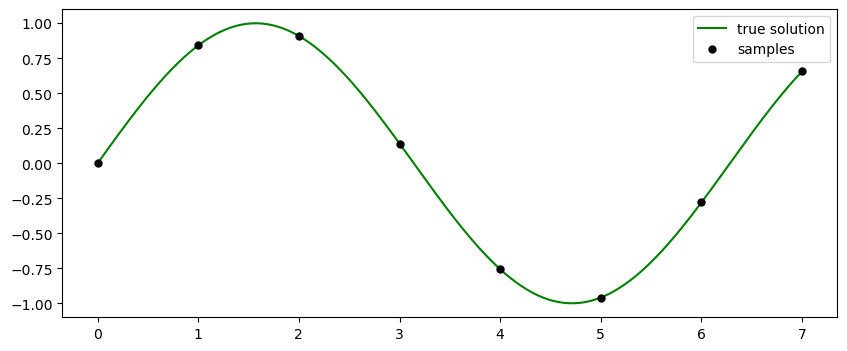

In [2]:
# make a figure object
fig = plt.figure(figsize=(10,4))

# make a simple sine curve over the period 0 to 7 increments of 1
t = np.arange(0,7.01,1)
y = np.sin(t)

# define the a more dense independent data set
dense_t = np.arange(0,7,0.01)
dense_y = np.sin(dense_t)

# plot the data
plt.plot(dense_t,dense_y,'g-',label='true solution')
plt.plot(t,y,'k.',markersize=10, label='samples')

# add a legend
plt.legend()

# show the plot
plt.show()

The idea of interpolation is the estimate the values at unknown locations (green curve) using the values at the samples (black dots). We can carry out simple interpolation with the `interp1d` function. There are three main types of interpolation: "nearest neighbor", linear, and cubic splines:

In [3]:
# create an interpolation function using interp1d
set_int_nn = interp1d(t, y, kind='nearest')
set_int_linear = interp1d(t, y, kind='linear')
set_int_cubic = interp1d(t, y, kind='cubic')

# compute the value of sin on the dense data points
dense_y_nn = set_int_nn(dense_t)
dense_y_linear = set_int_linear(dense_t)
dense_y_cubic = set_int_cubic(dense_t)

Let's see how each of these approach stack up:

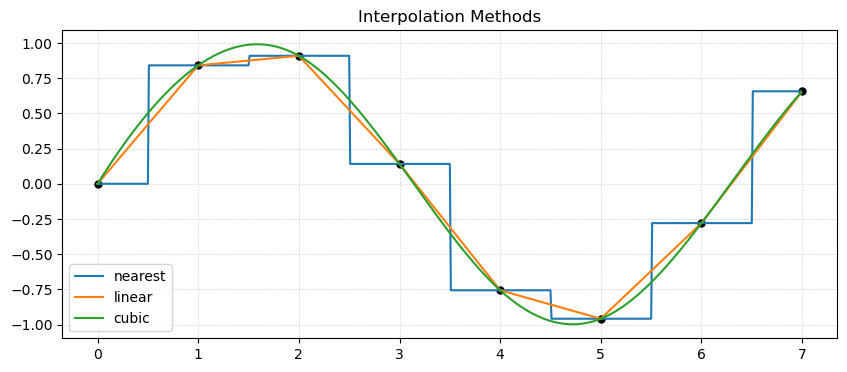

In [4]:
# make a figure
plt.figure(figsize=(10,4))

# plot the true solution
plt.plot(t,y,'k.',markersize=10)

# plot the dense data points
plt.plot(dense_t, dense_y_nn, label='nearest')
plt.plot(dense_t, dense_y_linear, label='linear')
plt.plot(dense_t, dense_y_cubic, label='cubic')

# add a grid to the plot
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

# add a legend
plt.legend(loc=3)

# add a title
plt.title('Interpolation Methods')

# show the plot
plt.show()

As we can see, the nearest neighbor interpolation assigns value to unknown points based on whichever value is closest. The linear method estimates values based on the straight line between the points. Finally, the cubic method fits a cubic polynomial to each set of three points. In this example, it appears to do a pretty good job. However, users should beware that cubic values can return very strange values - especially when the spacing of the independent data is highly irregular.

## 2D Interpolation
Let's consider the interpolation problem, but now in 2D. This time, let's consider a real world example - for example, what if you were going to sail from Iceland south to Antarctica. Along this journey, you may want to know what sea surface temperatures you might experience along the way. How can we estimate these values based on a grid of SST values?

To begin this exploration, let's read in a set of SST data. The `netCDF4` library provides us with a convenient way to read in data from netCDF files using the `Dataset` function. In this lesson, we will read in a map of Sea Surface Temperature from [NASA's MUR product](https://podaac.jpl.nasa.gov/MEaSUREs-MUR):

In [5]:
# define the file name
file_name = 'global_SST.nc'

# open the nc file
ds = nc4.Dataset(file_name)

# read in the variables as numpy arrays
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
sst = ds.variables['analysed_sst'][:, :, :]

# remove the time coordinate from the sst variable
sst = sst[0, :, :]

# close the dataset
ds.close()

Next, let's define the longitude and latitude values of our journey.

In [6]:
# define the longitude and latitudes you would experience on your journey
journey_lat = np.arange(65,-74,-0.01)
journey_lon = -23*np.ones_like(journey_lat)

Let's visualize the line of our journey on the map of sea surface temperature:

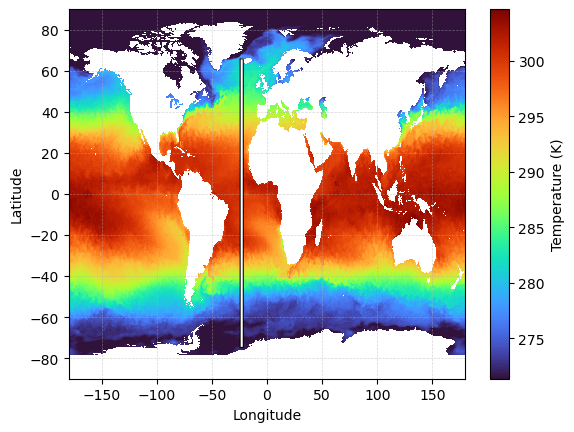

In [7]:
# make a new figure object
fig = plt.figure()

# plot the data 
C = plt.pcolormesh(lon, lat, sst, cmap='turbo')

# plot the journey line on the map
plt.plot(journey_lon, journey_lat, 'k-',linewidth=3)
plt.plot(journey_lon, journey_lat, 'w-')

# add a colorbar
cbar = plt.colorbar(C, label='Temperature (K)')

# add labels to the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# add gridlines
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

# show the plot
plt.show()

Next, we will use the `griddata` function for interpolation. Similar to `interp1d`, the `griddata` function takes in the points and values of the given data and returns the estimated values at the requested data locations. In particular, `griddata` takes in the following arguments:

- points (an array of points with shape (N,2))
- values (an array of points with shape (N,))
- destination points (two arrays of points for x and y)
- method (optional, default='linear')

Let's prepare these values and run the interpolation:

In [8]:
# define the points and values for the interpolation array
Lon, Lat = np.meshgrid(lon,lat)
points = np.column_stack([Lon.ravel(), Lat.ravel()])
values = sst.ravel()

# use the griddata function to interpolate onto the journey values
journey_sst = griddata(points, values, (journey_lon, journey_lat))

In [9]:
# filter out some values interpolated from land
journey_sst[journey_sst<0]=np.nan

Now that the interpolation is complete, let's make a plot of the temperature:

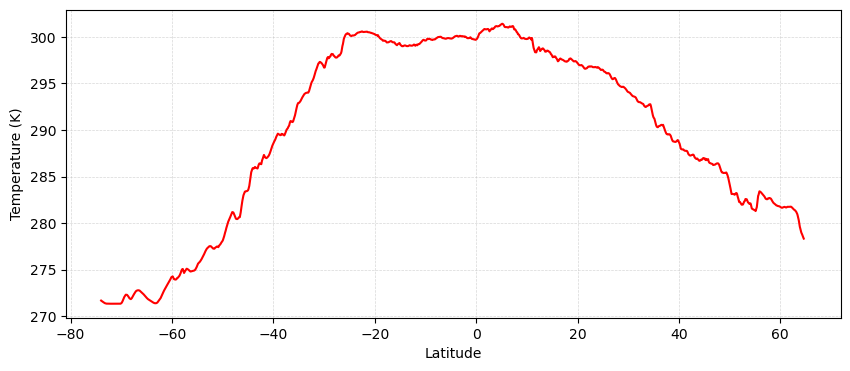

In [10]:
# make a new figure object
fig = plt.figure(figsize=(10,4))

# plot the timeseries
plt.plot(journey_lat, journey_sst, 'r-')

# add labels to the y axis
plt.ylabel('Temperature (K)')
plt.xlabel('Latitude')

# add gridlines
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

# show the plot
plt.show()

### &#x1F914; Mini-Exercise
Goal: Compare temperatures between two different locations.

The Galapagos Islands are located near the equator at -0.77$^{\circ}$N latitude and -91.14$^{\circ}$E longitude. On the other hand, South Georgia Island is located in the South Atlantic Ocean at -54.41$^{\circ}$N latitude and -36.58$^{\circ}$E longitude. Using the temperature dataset, compute the different in temperature between the two islands.

In [11]:
# define the longitude and latitudes
test_lat = np.array([-0.77, -54.41])
test_lon = np.array([-91.14, -36.58])

# define the points and values for the interpolation array
Lon, Lat = np.meshgrid(lon,lat)
points = np.column_stack([Lon.ravel(), Lat.ravel()])
values = sst.ravel()

# remove the negative values
points = points[values>0,:]
values = values[values>0]

# use the griddata function to interpolate onto the journey values
test_sst = griddata(points, values, (test_lon, test_lat),method='nearest')

In [12]:
print('The difference in temperature is '+'{:.2f}'.format(test_sst[0]-test_sst[1])+' degrees C')

The difference in temperature is 22.29 degrees C
